<a href="https://colab.research.google.com/github/7201krap/TILDA_Internship/blob/main/Path_finding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.youtube.com/watch?v=uCXm6avugCo
# <genetic algorithm from scratch in python -- full walkthrough>

In [ ]:
import numpy as np 
import random 
import copy
import matplotlib.pyplot as plt 
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [ ]:
# fix seeds
np.random.seed(42)
random.seed(42)
copy.deepcopy = lambda x: copy.copy(x)

In [ ]:
def initialize_map(p_zero, N):
    # first thing is to create the map that you are trying to navigate. I will do this randomly
    # this will be of the form of a adjacency matrix ...
    # In other words, an N x N matrix where each row and cloumn correspond to an intersection on a map
    # X_ij, then is equal to the amount of time that it takes to get from position i to j 
    # could also be considered a distance measure ... but whatever is easier to think about 
    # practically, then we need a matrix that has numeric values in it. 
    # there should be some paths that don't exist. I will assign these a 0.
    # For instance, if you can't get directly from i to j, then X_ij = 0 
    
    # the initialization needs some tuning parameters: p_zero. One is the proportion of 0's in the final result.
    m = np.zeros((N, N))   # N: the number of total nodes 
    
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                m[i][j] = random.random()* 100
                m[j][i] = m[i][j]
                
    return m

In [ ]:
def crossover(a, b):
    # you have to ensure that when the two routes crossover, the resulting routes produce a valid route 
    # which means that crossoever points have to be at the same position value on the map 
    # essentially, take a piece of one solution and the other piece of soltuion and we are going to mix them 
    # one-point crossover
    
    common_elements = list(set(a) & set(b))
    
    # there is no intersection 
    if len(common_elements) == 2:   
        # then we do not perform crossover and return as it was
        return (a, b)
    
    # there is an intersection or more intersections
    else:
        # remove 0 (=first location)
        common_elements.remove(0)
        
        # remove the destination (=last location)
        common_elements.remove(np.max(a))
        
        intersected_val = random.sample(common_elements, 1)[0]
        
        cut_a = np.random.choice(np.where(np.isin(a, intersected_val))[0])
        cut_b = np.random.choice(np.where(np.isin(b, intersected_val))[0])

        new_a1 = copy.deepcopy(a[0:cut_a])
        new_a2 = copy.deepcopy(b[cut_b:])

        new_b1 = copy.deepcopy(b[0:cut_b])
        new_b2 = copy.deepcopy(a[cut_a:])

        new_a = np.append(new_a1, new_a2)
        new_b = np.append(new_b1, new_b2)
        
        # we do not allow duplicated intersection in a single route
        has_duplicates_a = len(new_a) != len(set(new_a))
        has_duplicates_b = len(new_b) != len(set(new_b))
        
        if has_duplicates_a:
            return (a, b)
        if has_duplicates_b:
            return (a, b)

        return (new_a, new_b)

In [ ]:
def pick_mate(costs):
    '''
    parameters:
    input parameter 'costs' is directly from the function 'score_population'
    
    description:
    returns an index based on roulette wheel selection
    '''
    ranks = np.array(costs).argsort()
    
    fitnesses = [len(ranks) - x for x in ranks]   # fitnesses for routes. One fitness value for one route 
    
    fitnesses_sum = np.sum(fitnesses)
    
    select_prob = [fitness / fitnesses_sum for fitness in fitnesses]
    
    index = random.choices(range(len(select_prob)), select_prob)[0]
    
    return index

In [ ]:
def fitness(route, m):
    '''
    parameters: 
    route: 1d array, a list of intersections
    m: 2d matrix map
    
    description:
    calculates the toal cost of the route
    
    returns:
    the total cost of the route
    '''
    cost = 0 
    
    for i in range(1, len(route)):
        cost = cost + m[route[i-1]][route[i]]
        
    return cost

In [ ]:
def cost_population(population, m):
    '''
    parameters: 
    population: population size 
    m: map size 
    
    description:
    returns scores for routes. One score for one route 
    '''
    costs = []
    for i in range(0, len(population)):
        costs.append(fitness(population[i], m))   # population[i] refers to i-th route
    
    return costs

In [ ]:
def create_new_member(m):
    '''
    parameters:
    m: map size (2d matrix)
    
    description:
    this function returns a single route (1d array)
    '''
    # here we are going to create a new route 
    # the new route can have any number of steps, so we will select that randomly 
    # the structure of the route will be a vetor of integers (1d array) where each value is the next step in the route 
    # everyone starts at 0, so the first value in the vector will indicate where to attempt to go next 
    
    # N is the size of the map, so we need to make sure that 
    # we don't generate any values that exceed the size of the map
    
    N = len(m)   # m의 사이즈가 10x10이면 N은 10이다. 
    min_route_length = 20
    
    while True:
        route = [0]
        go = True   # go가 True이면 움직이고, go가 False이면 움직이지 않는다. 
        i = 1   # 몇번 움직이는지를 체크한다. 

        while go:
            # route[i-1]에 해당하는 row에서 0가 아닌 값들을 가진 index를 list로 반환.  
            possible_values = np.nonzero(m[route[i-1]])[0]   
            # index를 정해준다. 
            proposed_value_idx = random.randint(0, len(possible_values) - 1)
            # route에다가 다음 intersection을 append.
            route.append(possible_values[proposed_value_idx])

            if route[i] == N-1:
                go = False
            else:
                i = i + 1
        
        has_duplicates = len(route) != len(set(route))
        if has_duplicates:
            continue
        
        if len(route) >= min_route_length:
            break
            
    return route

In [ ]:
def create_starting_population(size, m):
    '''
    parameters:
    size: population size 
    m: map size 
    
    description:
    creates a population of different routes thus we have 'size' routes
    '''
    population = []
    
    print(f"Generating individuals ... Population size is {size}")
    for i in tqdm(range(size)):
        new_member = create_new_member(m)
        population.append(new_member)
        # print(f"Individual {i} \nLength: {len(new_member)}\n")
    print("Done!")
    
    return population

In [ ]:
# mutation V2
def mutate(route, mutation_probability, m):
    
    mutated_route = []
    N = len(m)
    
    for i in range(len(route)):
        if len(route) >= 3 and i != 0 and i != len(route) - 1 and random.random() < mutation_probability:
            current_element = route[i]
            left_neighbor = route[i-1]
            right_neighbor = route[i+1]
            
            # previous to current intersection 
            possible_values = np.nonzero(m[route[i-1]])[0]
            proposed_value_idx = random.randint(0, len(possible_values) - 1)
            val = possible_values[proposed_value_idx]
            
            # current to next intersection 
            # possible_values_next is a list containing possible next intersections
            possible_values_next = np.array(np.nonzero(m[val])[0])
            
            # I need to check 'val' and right_neighbor is connected or not.
            # if 'val' and right_neighor is connected then mutated_element = val 
            # otherwise ('val' and right_neighbour is not connected) mutated_element = route[i]
            if (right_neighbor in possible_values_next) and (val != left_neighbor) and (val != right_neighbor):
                mutated_element = val    
                
        else:
            mutated_element = route[i]
            
        mutated_route.append(mutated_element)
    
    # check if the mutated route contains duplicated intersections
    has_duplicates = len(mutated_route) != len(set(mutated_route))
    
    # if there is duplicated then return the original route
    if has_duplicates:
        return route
    # otherwise return the mutated route
    else:
        return mutated_route

In [ ]:
# route visualization 
def plot_best(the_map, route, iter_num):
    fig, ax = plt.subplots(figsize=(5, 5))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(the_map, cmap='jet')
    
    print("=== Plotting ===")
    print("WARNING: 'Length of lines' and 'Distance between points' are not proportional!")
    print("route:", route)   # [0, 16, 30, 16, 48, 52, 48, 34, 23, 43, 48, 43, 34, 52, 40, 72, 24, 29, 93, 99]
    print("cost:", fitness(route, the_map))
    x = route[:-1]
    y = route[1:]
    ax.plot(x, y, marker='o', linestyle='-', color='white')
    
    ax.set_title(f'Route visualization (Iteration:{iter_num})')
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

In [ ]:
ITERATIONS = 1000
def main(iterations=ITERATIONS):
    # hyperparameters
    sparseness_of_map = 0.7
    size_of_map = 50
    population_size = 100 
    num_of_crossovers = int(population_size * 0.1)
    num_of_remaining_indi = int(population_size * 0.8)
    mutation_prob = 0.001
    
    # initialization
    the_map = initialize_map(sparseness_of_map, size_of_map)
    population = create_starting_population(population_size, the_map)
    
    best_distances = []
    worst_distances = []
    avg_distances = []
    prev_best_distance = 0

    print("Population Size", len(population))
    
    for idx in range(iterations):
        new_population = []
        
        costs = cost_population(population, the_map)

        # best individual is the one with the lowest cost
        best_individual = population[np.argmin(costs)]   # 1d array with route
        best_distance = fitness(best_individual, the_map)
        
        # worst individual is the one with the highest cost 
        worst_individual = population[np.argmax(costs)] 
        worst_distance = fitness(worst_individual, the_map)
        
        # 10% of the population undergoes crossover
        for _ in range(num_of_crossovers):
            indi1, indi2 = crossover(population[pick_mate(costs)], population[pick_mate(costs)])
            new_population.append(indi1)
            new_population.append(indi2)
        
        # route visualization 
        if best_distance != prev_best_distance:
            plot_best(the_map, best_individual, idx)
        prev_best_distance = best_distance
        
        # mutation after crossover
        for idx2 in range(len(new_population)):
            new_population[idx2] = np.copy(mutate(new_population[idx2], mutation_prob, the_map))
        
        # top 90% of the population remains the same
        low_cost_indicies = np.argpartition(costs, num_of_remaining_indi-1)[:num_of_remaining_indi]
        for idx3 in range(len(low_cost_indicies)):
            new_population.append(population[low_cost_indicies[idx3]])
            
        population = copy.deepcopy(new_population)
        
        best_distances.append(best_distance)
        worst_distances.append(worst_distance)
        avg_distances.append(np.average(costs))
        
    return best_distances, worst_distances, avg_distances

Generating individuals ... Population size is 100


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


Population Size 100
=== Plotting Begins ===
route: [0, 21, 40, 28, 30, 31, 20, 5, 34, 36, 27, 22, 15, 23, 47, 3, 2, 32, 18, 49]
cost: 698.3044927302783


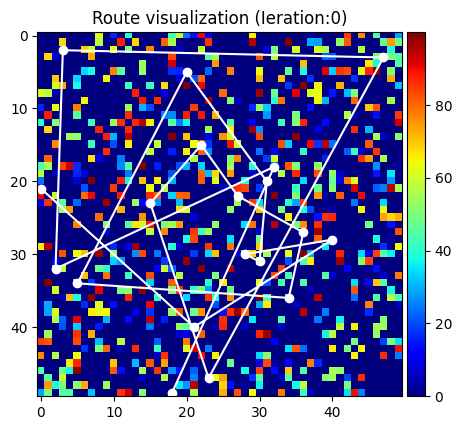

=== Plotting Begins ===
route: [ 0 20 42 47 25 48  6 37  8 43 11 35  2 44 49]
cost: 660.2906810184609


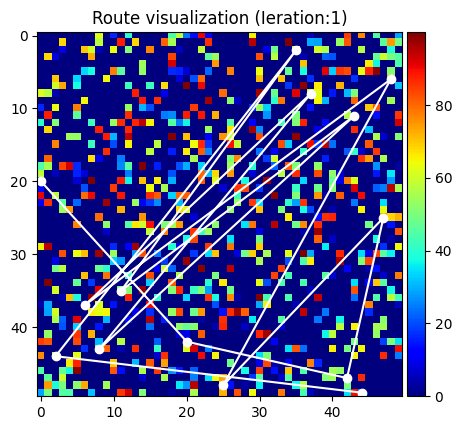

=== Plotting Begins ===
route: [ 0 29 12  7  3  1 37 31 11 18  4 49]
cost: 545.4074020332022


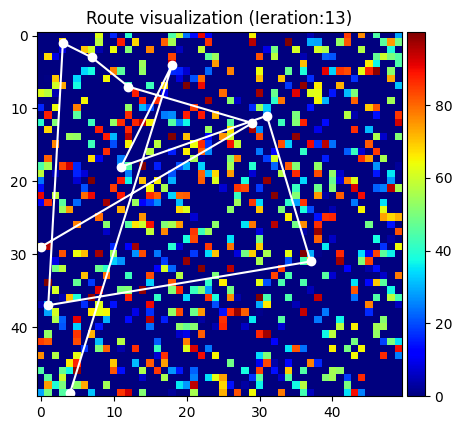

=== Plotting Begins ===
route: [ 0 29 12  7  3  1 49]
cost: 308.6078962793424


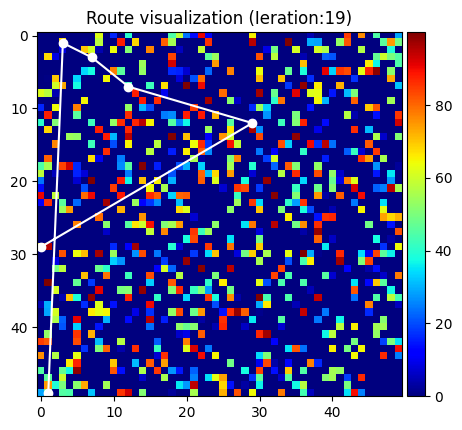

=== Plotting Begins ===
route: [ 0 37  1 13 38 25 21 10 31 11 18 49]
cost: 306.4086256053067


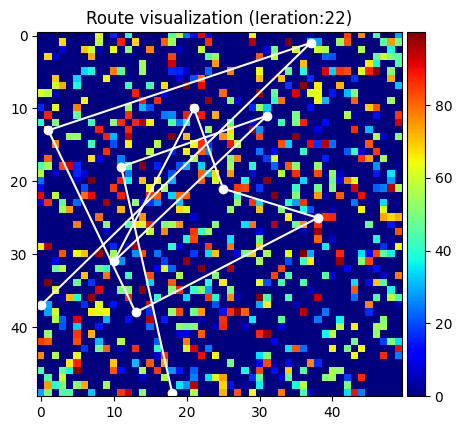

=== Plotting Begins ===
route: [ 0 20 42 47  3  2 32 18 49]
cost: 263.31527371619404


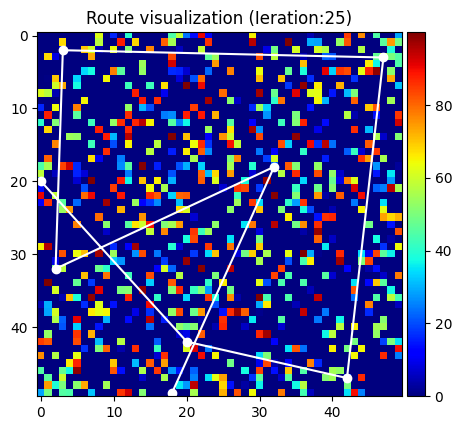

=== Plotting Begins ===
route: [ 0 21 27 49]
cost: 181.1078464470863


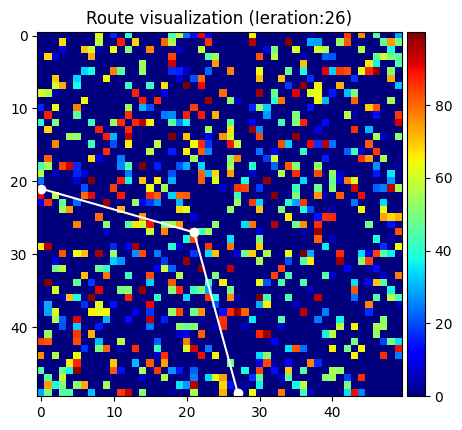

=== Plotting Begins ===
route: [ 0 37  1 49]
cost: 83.05589398966455


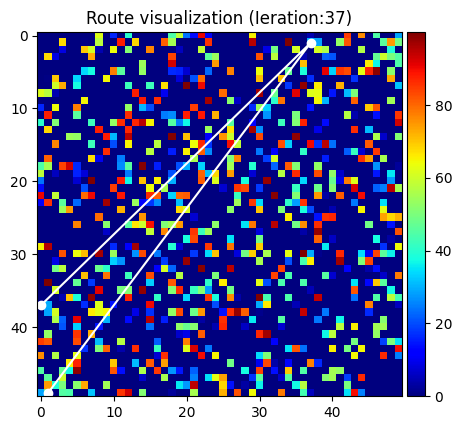

In [ ]:
best, worst, avg = main()

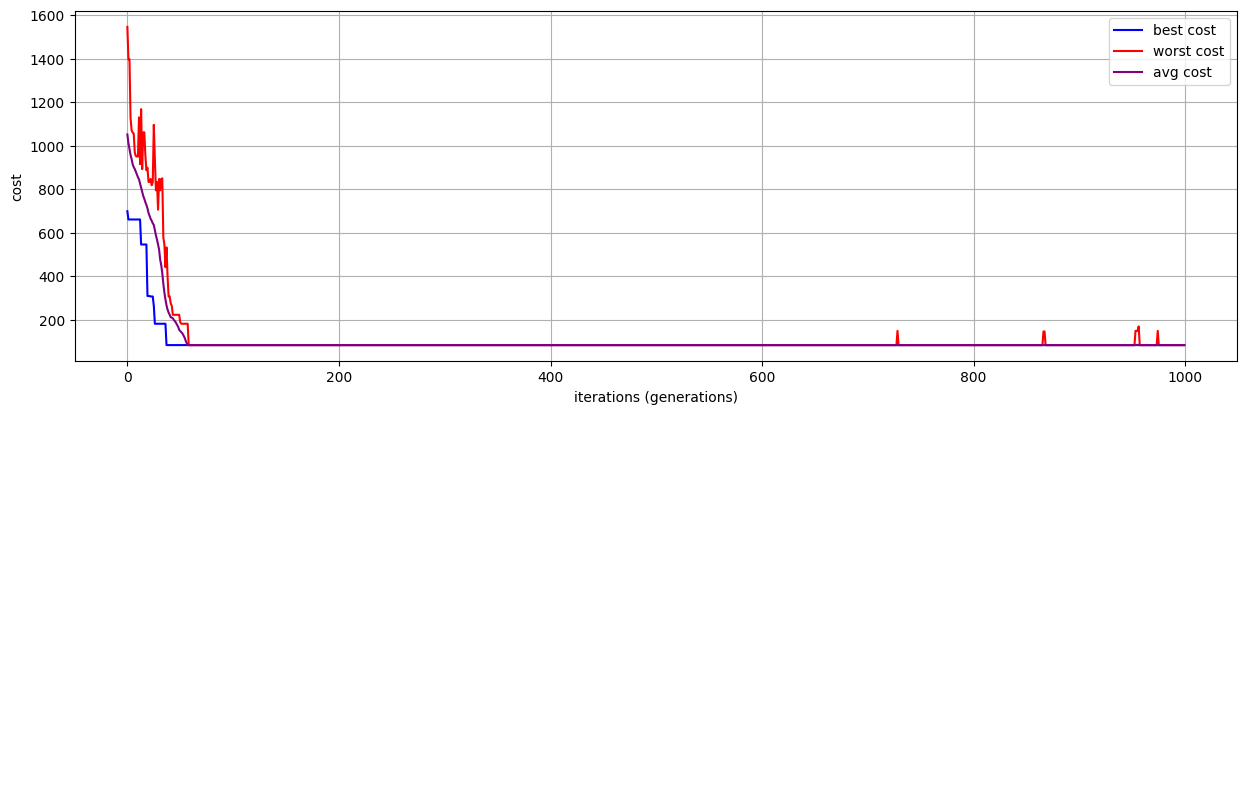

In [ ]:
# fitness(cost) visualization 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(np.arange(0, ITERATIONS), best, label='best cost', c='blue')
ax1.plot(np.arange(0, ITERATIONS), worst, label='worst cost', c='red')
ax1.plot(np.arange(0, ITERATIONS), avg, label='avg cost', c='purple')
ax1.legend()
ax1.set_xlabel('iterations (generations)')
ax1.set_ylabel('cost')
ax1.grid()

ax2.axis('off')
# ax2.plot(np.arange(0, ITERATIONS), best, label='best cost', c='blue')
# ax2.plot(np.arange(0, ITERATIONS), worst, label='worst cost', c='red')
# ax2.plot(np.arange(0, ITERATIONS), avg, label='avg cost', c='purple')
# ax2.legend()
# ax2.set_xlabel('iterations (generations)')
# ax2.set_ylabel('cost')
# ax2.grid()
# ax2.set_ylim([0, 1000])
plt.show()